In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

In [6]:
%%time
reads_filenames = (
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)

9it [00:00, 44150.57it/s]
6it [00:00, 35049.89it/s]

CPU times: user 5.89 ms, sys: 354 μs, total: 6.24 ms
Wall time: 12.5 ms


## Subset of reads with at least 3 SNPs 

In [7]:
%%time
def F(filename):
     return (
         pl.scan_parquet(filename)
        .select(
            'read_name',
            'read_length',
            'chrom',
            'sample_id',
            'grch37_chromosome_size_in_bp',
            'high_quality_snp_positions',
            "high_quality_snp_positions_alleles",
            'CO_active_interval_start',
            'CO_active_interval_end',
            'CO_active_interval_length_bp',
            'NCO_active_interval_start',
            'NCO_active_interval_end',
            'NCO_active_interval_length_bp',
            'grch37_reference_start',
            'grch38_reference_start',
            'grch37_reference_end',
            'grch38_reference_end',
            'T2T_reference_start',
            'grch37_reference_start_cM',
            'grch37_reference_end_cM',
            'CO_active_interval_start_cM',
            'CO_active_interval_end_cM',
            'CO_active_interval_crossover_prob',
            'NCO_active_interval_start_cM',
            'NCO_active_interval_end_cM',
            'NCO_active_interval_crossover_prob',
            "NCO_prob_detection_in_CO_active_interval",
            "full_read_crossover_prob",
            'AA_motif_center_pos',
            'AA_heat',
            'AA_motif_strand',
            'CL4_motif_center_pos',
            'CL4_heat',
            'CL4_motif_strand',
            'is_high_quality_read', 
            "high_quality_classification_class",
            "snp_positions_on_read", 
            "idx_transitions",
            "high_quality_classification_in_detectable_class",
            "H3K4me3_signal_mean",
            "CTCF_signal_mean",  
            "total_mismatches",
            "is_contamination",
        )                  
        .collect()
#        .filter(pl.col("high_quality_classification_class").is_in(["CO", "GC"]))         # REMOVE THAT IS YOU NEED ALL
        .filter("is_high_quality_read")
        .filter(~pl.col("is_contamination"))
        # .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
        # .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    )

dense_reads_with_detection_df = pl.concat(
    joblib.Parallel(n_jobs=-1, verbose=1)(
        joblib.delayed(F)(filename) for filename in reads_filenames
    )
)

[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:  8.1min


CPU times: user 3min 42s, sys: 1min 48s, total: 5min 30s
Wall time: 11min 51s


## Add annotation for CO and NCO reads only

In [8]:
CO_NCO_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_classification_class").is_in(["CO", "GC"]))
    .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)             
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch37_first_converted_marker_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
        grch38_first_converted_marker_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
    )
)

dfs = []
for [chrom], df in CO_NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
            grch37_first_converted_marker_poses_rate = rate_map.get_rate(df["grch37_first_converted_marker_pos"]) * 1e2,            
        )
    )
    
CO_NCO_df = pl.concat(dfs)

In [9]:
CO_NCO_df = (CO_NCO_df
    .with_columns(
        (pl.col("full_read_crossover_prob") * 1e2).alias("genetic_length_in_cm"),
        (pl.col("read_length")).alias("genetic_length_in_bp"),
        (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1, null_on_oob=True)) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0, null_on_oob=True)+1)
        ).alias("lower_bound"),
        (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1, null_on_oob=True)+1) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0, null_on_oob=True))
        ).alias("upper_bound"),
        pl.col("idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"),     
    )
    .with_columns(
        (pl.col("genetic_length_in_cm")/(pl.col("genetic_length_in_bp")*1e-6)).alias("read_recomb_rate_in_cm_bp"),
    )
)

In [8]:
dense_reads_with_detection_df.group_by("high_quality_classification_class").len()

high_quality_classification_class,len
str,u32
"""CO""",7143
"""GC""",2382


In [26]:
(dense_reads_with_detection_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .select(pl.col("idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

n_converted,len
i64,u32
1,2222
2,122
3,24
4,8
5,3
6,1
8,1
10,1


In [28]:
2222/2382

0.9328295549958019

# Differences in genetic lengths

## Different chromosomes and samples?

In [12]:
def test_condition(condition):
    df = (dense_reads_with_detection_df
        .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
        .filter(condition)
        .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
        .select(
            "CO_active_interval_crossover_prob",
            "high_quality_classification_in_detectable_class",
        )
    )

    CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
    NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
    
    return len(CO_lens), len(NCO_lens), scipy.stats.ks_2samp(CO_lens, NCO_lens).pvalue, inference.permutation_testing([[CO_lens, NCO_lens]], 1000)

In [19]:
rows = []
for sample_id in tqdm.tqdm(sorted(sample_ids)):
    rows.append([sample_id] + list(test_condition(pl.col("sample_id") == sample_id)))
    
with pl.Config(tbl_rows=100) as cfg:
    display(pl.DataFrame(rows, schema=["sample_id", "n_events_CO", "n_events_NCO", "KS_pvalue", "AD_perm_pvalue"]))    

100%|██████████| 15/15 [00:44<00:00,  2.95s/it]
/tmp/ipykernel_3137616/240028375.py:6: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  display(pl.DataFrame(rows, schema=["sample_id", "n_events_CO", "n_events_NCO", "KS_pvalue", "AD_perm_pvalue"]))


sample_id,n_events_CO,n_events_NCO,KS_pvalue,AD_perm_pvalue
str,i64,i64,f64,f64
"""115980""",325,86,1.1051e-13,0.0
"""1894""",379,113,7.3519e-27,0.0
"""2895""",288,72,1.8786e-9,0.0
"""3898""",331,100,3.6862e-7,0.0
"""7899""",394,100,9.6606e-10,0.0
"""95619""",331,87,1.8976e-9,0.0
"""PD46180c""",445,114,2.8953e-19,0.0
"""PD50477f""",377,82,0.001038,0.0
"""PD50489e""",272,43,0.000491,0.0


### See visually

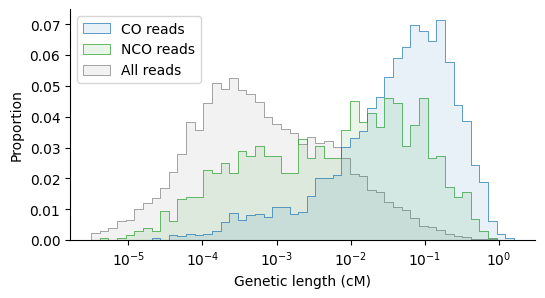

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = dense_reads_with_detection_df.filter(pl.col("CO_active_interval_crossover_prob") > 0).sample(fraction=1e-4)["CO_active_interval_crossover_prob"] * 1e2

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)

fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/revision/fig_co_vs_nco_cms.pdf")

### Quantify NCOs as mixture of COs and all reads?

In [21]:
import sklearn.neighbors

CO_kde = sklearn.neighbors.KernelDensity().fit(np.log10(CO_lens).reshape((-1, 1)))
all_kde = sklearn.neighbors.KernelDensity().fit(np.log10(all_lens).reshape((-1, 1)))

In [22]:
def score(p): 
    return np.log(np.exp(CO_kde.score_samples(np.log10(NCO_lens).reshape((-1,1)))) * p + \
                  np.exp(all_kde.score_samples(np.log10(NCO_lens).reshape((-1,1)))) * (1-p)).sum()

In [23]:
ps = np.linspace(0, 1, 101)
log_probs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(score)(p) for p in ps
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   31.0s finished
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   41.8s finished


Max at: 0.55


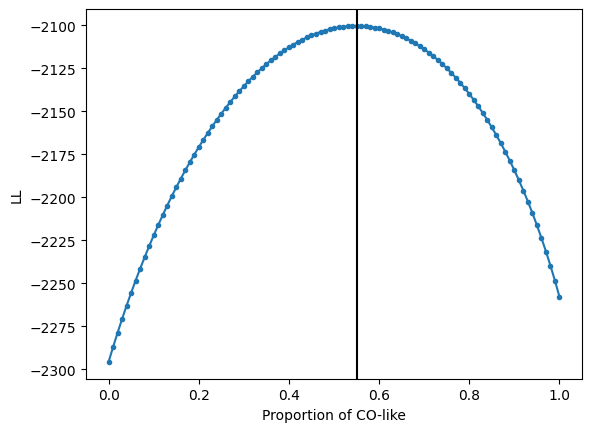

In [24]:
plt.plot(ps, log_probs, '.-')
plt.xlabel("Proportion of CO-like");
plt.ylabel("LL");
plt.axvline(ps[np.array(log_probs).argmax()], c='black')
print("Max at:", ps[np.array(log_probs).argmax()])

In [26]:
len(CO_lens), len(NCO_lens), len(all_lens)

(5331, 1285, 9177)

In [27]:
len(CO_lens)/55*45

4361.727272727272

In [32]:
scipy.stats.ks_2samp(
    np.concatenate([CO_lens, all_lens[:4361]]),
    NCO_lens.to_numpy(),
)

KstestResult(statistic=np.float64(0.0788057381353469), pvalue=np.float64(1.409924362040517e-06), statistic_location=np.float64(0.0488395023810142), statistic_sign=np.int8(-1))

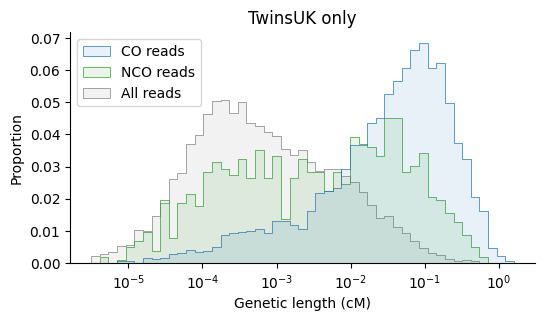

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
    .filter(pl.col("sample_id").is_in(rahbari_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["CO_active_interval_crossover_prob"] * 1e2

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)
ax.set_title("TwinsUK only");
#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/fig_co_vs_nco_cms.pdf")

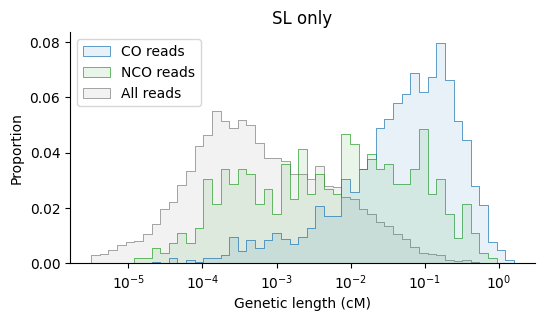

In [24]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
    .filter(pl.col("sample_id").is_in(sudmant_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["CO_active_interval_crossover_prob"] * 1e2

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)
ax.set_title("SL only");
#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/fig_co_vs_nco_cms.pdf")

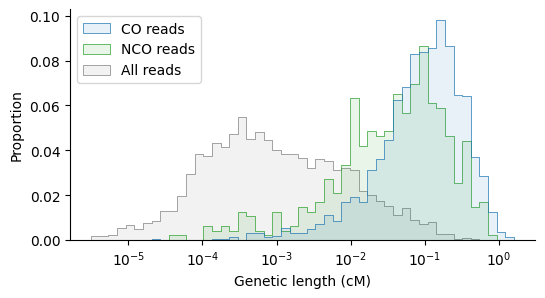

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .filter(pl.col("AA_heat").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["CO_active_interval_crossover_prob"] * 1e2

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)



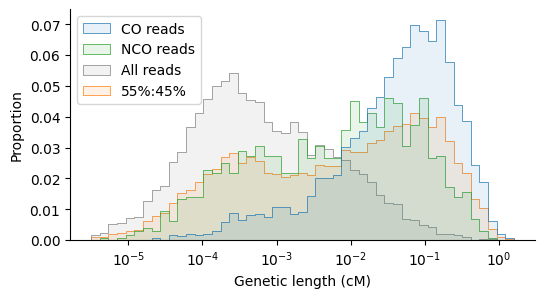

In [33]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)      
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = dense_reads_with_detection_df.filter(pl.col("CO_active_interval_crossover_prob") > 0).sample(fraction=1e-4)["CO_active_interval_crossover_prob"] * 1e2

fake_NCO_lens = np.concatenate([
    CO_lens,
    all_lens.sample(n=len(CO_lens)//1.2),
])

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
        pd.Series(np.log10(fake_NCO_lens), name="55%:45%"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color, "C1"],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads", "55%:45%"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)


In [55]:
(1/1.2)/(1 + 1/1.2)

0.45454545454545453

### High minimal number of SNPs

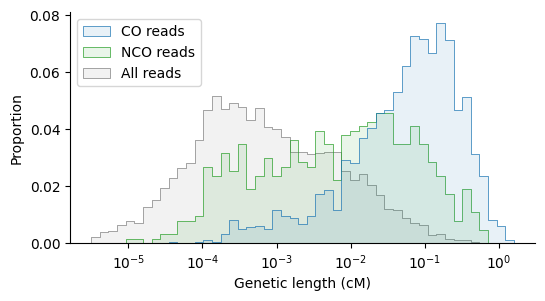

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 15)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["CO_active_interval_crossover_prob"] * 1e2

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/fig_co_vs_nco_cms.pdf")

### No mismatches

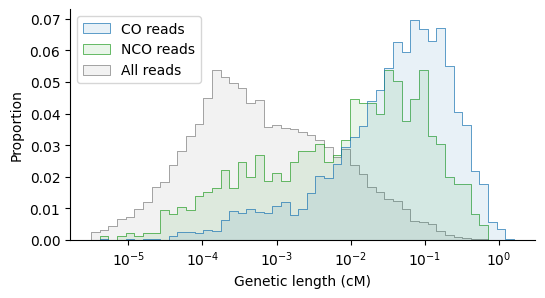

In [11]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
    .filter(pl.col("total_mismatches") == 0)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["CO_active_interval_crossover_prob"] * 1e2

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/fig_co_vs_nco_cms.pdf")

### Is this age-related?

In [17]:
df = (dense_reads_with_detection_df
    .filter(pl.col("sample_id").is_in(rahbari_sample_ids+sudmant_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO") 
    .select(
        "sample_id",
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
        active_internal_genetic_length = pl.col("CO_active_interval_crossover_prob") * 1e2,
    )
)


In [19]:
# Original data in a flat list
data = [
    "AA1-s1", 62, "AA1-s2", 74, "AA2-t1", 24, "AA2-t2", 36, "AA3", 74, "AA4", 47,
    "AA5", 62, "AA6", 31, "AA7", 32, "AA8", 31, "AA9", 28, "AN-s1", 27, "AN-s2", 40, "AB", 33, "AD", 26
]

# Create a Polars DataFrame
age_df = pl.DataFrame([(data[i], data[i+1]) for i in range(0, len(data), 2)], schema=["paper_label_id", "age"], orient="row")


In [27]:
adf = (df
    .group_by("sample_id")
    .agg(frac_NCO_mitotic = (pl.col("active_internal_genetic_length").log(base=10) <= -3).mean())
    .join(
        pl.DataFrame(
            {
                "sample_id": sample_presentation_order, 
                "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
            }
        ),
        on="sample_id",
        how="left",
    )  
    .join(age_df, on="paper_label_id")
    .select("paper_label_id", "frac_NCO_mitotic", "age")
    .sort("paper_label_id")
)

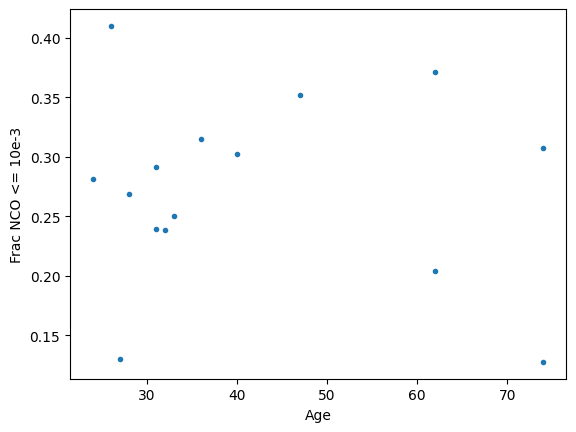

In [28]:
plt.plot(
    adf["age"],
    adf["frac_NCO_mitotic"],
    '.',
)

plt.xlabel("Age");
plt.ylabel("Frac NCO <= 10e-3");

In [29]:
scipy.stats.pearsonr(
    adf["age"],
    adf["frac_NCO_mitotic"],
)

PearsonRResult(statistic=np.float64(-0.1184683943884738), pvalue=np.float64(0.674114907566795))

### NCOs - short vs. long

In [19]:
CO_NCO_df.columns

['read_name',
 'read_length',
 'chrom',
 'sample_id',
 'grch37_chromosome_size_in_bp',
 'high_quality_snp_positions',
 'high_quality_snp_positions_alleles',
 'CO_active_interval_start',
 'CO_active_interval_end',
 'CO_active_interval_length_bp',
 'NCO_active_interval_start',
 'NCO_active_interval_end',
 'NCO_active_interval_length_bp',
 'grch37_reference_start',
 'grch38_reference_start',
 'grch37_reference_end',
 'grch38_reference_end',
 'T2T_reference_start',
 'grch37_reference_start_cM',
 'grch37_reference_end_cM',
 'CO_active_interval_start_cM',
 'CO_active_interval_end_cM',
 'CO_active_interval_crossover_prob',
 'NCO_active_interval_start_cM',
 'NCO_active_interval_end_cM',
 'NCO_active_interval_crossover_prob',
 'NCO_prob_detection_in_CO_active_interval',
 'full_read_crossover_prob',
 'AA_motif_center_pos',
 'AA_heat',
 'AA_motif_strand',
 'CL4_motif_center_pos',
 'CL4_heat',
 'CL4_motif_strand',
 'is_high_quality_read',
 'high_quality_classification_class',
 'snp_positions_on_re

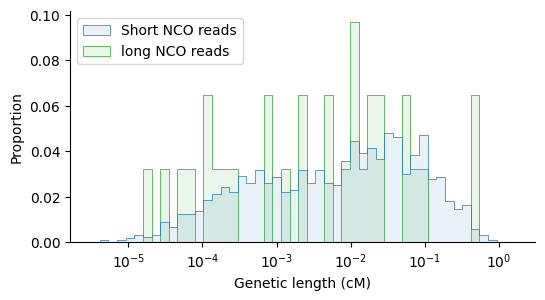

In [27]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (CO_NCO_df
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
        "n_converted",
        "lower_bound",
    )
)
short_NCO_lens = (df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter((pl.col("n_converted") == 1) | ((pl.col("n_converted") > 1) & (pl.col("lower_bound") <= 100)))
    ["CO_active_interval_crossover_prob"] * 1e2
)
    
long_NCO_lens = (df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter((pl.col("n_converted") > 1) & (pl.col("lower_bound") > 100))
    ["CO_active_interval_crossover_prob"] * 1e2
)


sns.histplot(
    [
        pd.Series(np.log10(short_NCO_lens), name="Short NCO"),
        pd.Series(np.log10(long_NCO_lens), name="Long NCOs"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["Short NCO reads", "long NCO reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/fig_co_vs_nco_cms.pdf")

In [28]:
scipy.stats.ks_2samp(short_NCO_lens, long_NCO_lens)

KstestResult(statistic=np.float64(0.14653704043395088), pvalue=np.float64(0.48838911683012626), statistic_location=np.float64(0.0002714908679999628), statistic_sign=np.int8(-1))

### Overlap with DSBs?

In [40]:
df = (CO_NCO_df
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
        "n_converted",
        "lower_bound",
        "AA_motif_center_pos",
    )
)
short_NCO_overlaps = (df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter((pl.col("n_converted") == 1) | ((pl.col("n_converted") > 1) & (pl.col("lower_bound") <= 1000)))
    ["AA_motif_center_pos"].is_not_null().cast(int)
)
    
long_NCO_overlaps = (df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter((pl.col("n_converted") > 1) & (pl.col("lower_bound") > 1000))
    ["AA_motif_center_pos"].is_not_null().cast(int)
)

In [41]:
scipy.stats.ks_2samp(short_NCO_overlaps, long_NCO_overlaps)

KstestResult(statistic=np.float64(0.03907496012759171), pvalue=np.float64(1.0), statistic_location=np.int64(0), statistic_sign=np.int8(1))

In [43]:
short_NCO_overlaps.mean()

0.4609250398724083

In [44]:
long_NCO_overlaps.mean()

0.5

# DSBs

## Compare distance to motif distributions, CO vs. NCO

In [12]:
def grenander(data, p, k):
    n = len(data)
    assert (k > 0) and (k < n - 1)

    data = np.sort(data).astype(float)
    diff = data[k:] - data[:-k]
    tot = data[k:] + data[:-k]

    # Limiting value
    if np.any(diff == 0):
        return np.nanmean(np.where(diff == 0, tot, np.nan)) / 2

    b = (tot / diff**p).sum() / 2
    a = (1 / diff**p).sum()

    assert np.isfinite(b / a), f"b/a not finite: {b}/{a}, p={p}, k={k}"

    return b / a


def estimate_mode(data, p=10, k=100):
    return grenander(data, p, k)

### Overall

In [75]:
(CO_NCO_df
    .group_by("high_quality_classification_in_detectable_class", pl.col("AA_motif_center_pos").is_not_null())
    .len()
    .sort("high_quality_classification_in_detectable_class", "AA_motif_center_pos")
)

high_quality_classification_in_detectable_class,AA_motif_center_pos,len
str,bool,u32
null,false,814
null,true,1001
"""CO""",false,1681
"""CO""",true,3917
"""NCO""",false,680
"""NCO""",true,582


In [76]:
scipy.stats.fisher_exact([[1681, 3917], [680, 582]])

SignificanceResult(statistic=np.float64(0.3673061616783553), pvalue=np.float64(6.565470403812711e-56))

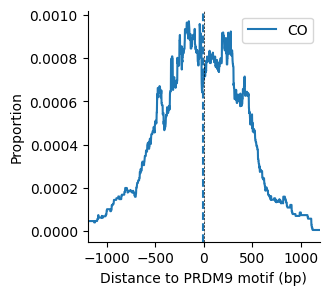

In [26]:
fig, ax = plt.subplots(figsize=(3, 3))

xs, H_CO = inference.calculate_motif_distance_histogram(
    (CO_NCO_df
        .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    grch38_recombining_interval_threshold=500,
)

xs, H_NCO = inference.calculate_motif_distance_histogram(
    (CO_NCO_df
        .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
    grch38_recombining_interval_threshold=1000,
)

z = len(xs)//2
center_xs = xs[z-2000:z+2000]
center_H_CO = H_CO[z-2000:z+2000]
center_H_CO /= center_H_CO.sum()

n_reads = len(CO_NCO_df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
    .filter(pl.col("AA_motif_center_pos").is_not_null())
)

est_mode = estimate_mode(np.concatenate([[x]*int(cnt) for x, cnt in zip(center_xs, n_reads*center_H_CO) if cnt]), p=50, k=500)
est_median = np.median(np.concatenate([[x]*int(cnt) for x, cnt in zip(center_xs, n_reads*center_H_CO) if cnt]))

smoothed_H_CO = scipy.ndimage.uniform_filter1d(H_CO, 500)

ax.plot(xs, H_CO, label="CO", color=CO_color);
#ax.plot(xs, smoothed_H_CO, label="CO (smooth)", color="C1");

    

#plt.plot(xs, H_NCO, label="NCO");
#plt.title("Distance to motif in A/A hotspot");
ax.set_xlabel("Distance to PRDM9 motif (bp)");

ax.set_xlim(-1200,1200);
ax.axvline(est_median, color=CO_color, ls="--");
ax.axvline(0, color="black", ls="--", lw=0.5, alpha=1);
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel("Distance to PRDM9 motif (bp)");
ax.set_ylabel("Proportion");
ax.legend(loc="upper right");

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/co_dist_to_motif.pdf")

In [27]:
z = len(xs)//2
center_xs = xs[z-2000:z+2000]
center_H_CO = H_CO[z-2000:z+2000]
center_H_CO /= center_H_CO.sum()

n_reads = len(CO_NCO_df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
    .filter(pl.col("AA_motif_center_pos").is_not_null())
)

print("Mode:", estimate_mode(np.concatenate([[x]*int(cnt) for x, cnt in zip(center_xs, n_reads*center_H_CO) if cnt]), p=50, k=500))
print("Mean abs:", np.sum(np.abs(center_xs)*center_H_CO))
print("Median:", np.median(np.concatenate([[x]*int(cnt) for x, cnt in zip(center_xs, n_reads*center_H_CO) if cnt])))

Mode: -102.7465474449232
Mean abs: 391.3327643699509
Median: -8.5


In [28]:
z = len(xs)//2
center_xs = xs[z-2000:z+2000]
center_H_CO = smoothed_H_CO[z-2000:z+2000]
center_H_CO /= center_H_CO.sum()

n_reads = len(CO_NCO_df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
    .filter(pl.col("AA_motif_center_pos").is_not_null())
)

print("Mode:", estimate_mode(np.concatenate([[x]*int(cnt) for x, cnt in zip(center_xs, n_reads*center_H_CO) if cnt]), p=50, k=500))
print("Mean abs:", np.sum(np.abs(center_xs)*center_H_CO))
print("Median:", np.median(np.concatenate([[x]*int(cnt) for x, cnt in zip(center_xs, n_reads*center_H_CO) if cnt])))

Mode: -8.999999982423686
Mean abs: 406.38228580163025
Median: -12.0


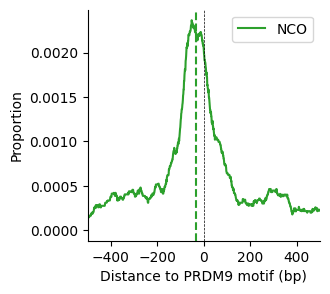

In [13]:
NCO_df = (CO_NCO_df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
)        

xs, H = inference.calculate_motif_distance_to_converted_snps_histogram(
    (NCO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

n_reads = len(NCO_df.filter(pl.col("AA_motif_center_pos").is_not_null()))
est_mode = estimate_mode(np.concatenate([[x]*int(cnt) for x, cnt in zip(xs, H*n_reads) if cnt]))
est_median = np.median(np.concatenate([[x]*int(cnt) for x, cnt in zip(xs, H*n_reads) if cnt]))

#plt.plot(xs, H, alpha=0.8);
fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(
    xs,
    scipy.ndimage.uniform_filter1d(H, 100),
    color=NCO_color,
    label="NCO",
)
#plt.plot(xs, H[::-1], color="teal", alpha=0.2);
#plt.title("NCOs - Distance to motif in A/A hotspot");
ax.set_xlim(-500,500);
#ax.axvline(est_mode, color=NCO_color, ls="--");
ax.axvline(est_median, color=NCO_color, ls="--");
ax.axvline(0, color="black", ls="--", lw=0.5, alpha=1);
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel("Distance to PRDM9 motif (bp)");
ax.set_ylabel("Proportion");


ax.legend(loc="upper right");

fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/revision/nco_dist_to_motif.pdf")

In [18]:
z = len(xs)//2
center_xs = xs[z-2000:z+2000]
center_H = H[z-2000:z+2000]
center_H /= center_H.sum()

n_reads = len(CO_NCO_df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter(pl.col("AA_motif_center_pos").is_not_null())
)

print("Mode:", estimate_mode(np.concatenate([[x]*int(cnt) for x, cnt in zip(center_xs, n_reads*center_H) if cnt]), p=50, k=100))
print("Mean abs:", np.sum(np.abs(center_xs)*center_H))
print("Median:", np.median(np.concatenate([[x]*int(cnt) for x, cnt in zip(center_xs, n_reads*center_H) if cnt])))

Mode: -35.768245026410874
Mean abs: 285.293135783946
Median: -34.0


### Per sample

In [16]:
rows = []
for sample_id in tqdm.tqdm(sample_id_order):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (CO_NCO_df
            .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id))
        ),
        (CO_NCO_df
            .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        n_perms=1000,
        stat="sum_abs",
    )
    
    rows.append(
        [
            sample_id, 
            pval,
        ]
    )
    
motif_dists_co_vs_nco_df = pl.DataFrame(
    rows,
    schema=[
        "sample_id", 
        "perm_pval"
    ],
)       

100%|██████████| 15/15 [01:00<00:00,  4.02s/it]


In [17]:
motif_dists_co_vs_nco_df.sort("perm_pval")

sample_id,perm_pval
str,f64
"""3898""",0.019
"""115980""",0.051
"""1894""",0.072
"""PD50508b""",0.091
"""2895""",0.096
"""7899""",0.098
"""PD50519d""",0.127
"""PD50489e""",0.16
"""95619""",0.202


# Compare DSB signal strengths between CO and NCO

## Overall

In [10]:
heats_CO = (CO_NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())            
    .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
)["AA_heat"].fill_null(0).to_numpy()

heats_NCO = (CO_NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())             
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
)["AA_heat"].fill_null(0).to_numpy()

5.936501230576512e-54 0.0 0.669 6.565470403812711e-56


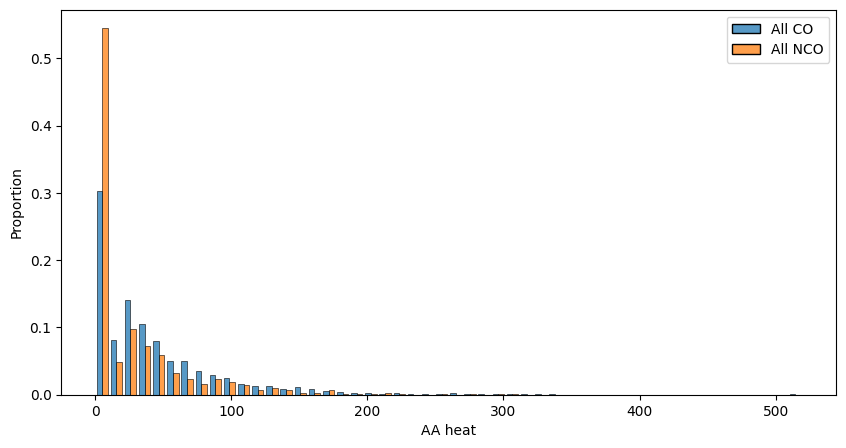

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(
    [
        pd.Series(heats_CO, name="All CO"),
        pd.Series(heats_NCO, name="All NCO"),
    ], 
    bins=50, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("AA heat");
#plt.title(f"AD perm pval = {pval}");

print(
    scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
    inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
    inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
    scipy.stats.fisher_exact(
        [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
         [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
    ).pvalue,
)

## Per sample

In [17]:
rows = []
for sample_id in tqdm.tqdm(sample_id_order):
    heats_CO = (CO_NCO_df
        .filter(pl.col("grch38_reference_start").is_not_null())                
        #.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
        .filter(pl.col("high_quality_classification_class") == "CO")
        .filter((pl.col("sample_id") == sample_id))
    )["AA_heat"].fill_null(0).to_numpy()

    heats_NCO = (CO_NCO_df
        .filter(pl.col("grch38_reference_start").is_not_null())                 
        #.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
        .filter(pl.col("high_quality_classification_class") == "GC")
        .filter((pl.col("sample_id") == sample_id))
    )["AA_heat"].fill_null(0).to_numpy()
    
    rows.append(
        [
            sample_id, 
            len(heats_CO), 
            len(heats_NCO),
            (heats_CO == 0).sum(),
            (heats_NCO == 0).sum(),
            scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
            inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
            inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
                 [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
            ).pvalue,
        ]
    )
    
AA_heats_co_vs_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_CO", "n_NCO", "n_CO_zeros", "n_NCO_zeros",
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

100%|██████████| 15/15 [00:09<00:00,  1.65it/s]
/tmp/ipykernel_1505235/3198893078.py:34: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  AA_heats_co_vs_nco_df = pl.DataFrame(


In [13]:
AA_heats_co_vs_nco_df.sort("heats_AD_perm_pvalue")

sample_id,n_CO,n_NCO,n_CO_zeros,n_NCO_zeros,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,i64,i64,i64,i64,f64,f64,f64,f64
"""PD50508b""",371,96,90,43,0.002655,0.0,0.194,0.000126
"""PD46180c""",657,176,137,91,3.3313e-12,0.0,0.819,5.5991e-15
"""PD50489e""",445,115,149,72,5.9086e-8,0.0,0.403,2.9497e-8
"""1894""",413,153,120,104,1.2946e-17,0.0,0.159,8.4450e-17
"""3898""",364,152,99,79,0.000002,0.0,0.587,1.0898e-7
"""7899""",412,145,109,70,0.000013,0.0,0.762,0.000003
"""115980""",353,122,92,59,0.000038,0.0,0.917,0.000009
"""PD50521e""",532,178,168,98,2.1917e-7,0.0,0.514,3.7760e-8
"""2895""",313,110,101,59,0.000953,0.0,0.441,0.000096


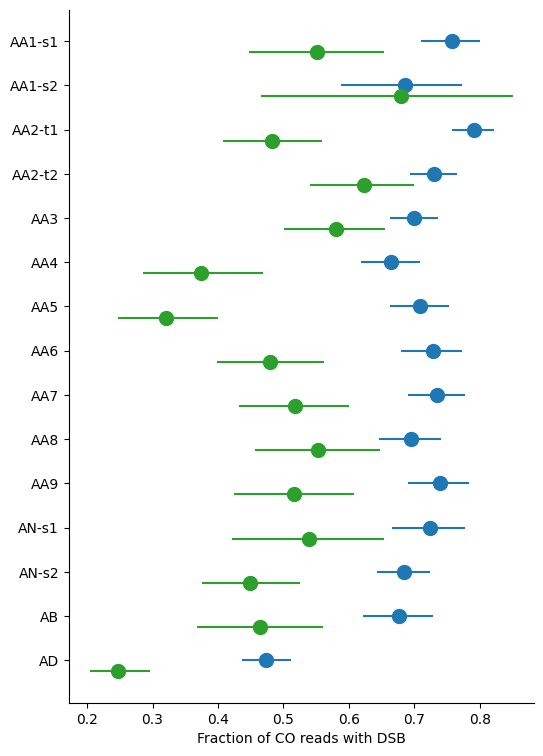

In [18]:
fig, ax = plt.subplots(figsize=(6,9))

rows = AA_heats_co_vs_nco_df.rows(named=True)
Drows = {}
for row in rows:
    Drows[row["sample_id"]] = row

# COs
mns_co = [(1 - Drows[s]["n_CO_zeros"]/Drows[s]["n_CO"]) \
       for s in sample_presentation_order[:-1]]
cis_co = [statsmodels.stats.proportion.proportion_confint(
    Drows[s]["n_CO"] - Drows[s]["n_CO_zeros"],
    Drows[s]["n_CO"],
    method="beta",
) for s in sample_presentation_order[:-1]]
    
ax.errorbar(
    y = 2*np.arange(len(sample_presentation_order[:-1])),
    x = mns_co,
    xerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis_co, mns_co)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis_co, mns_co)],
    ],
    fmt=".",
    ms=20,
    color=CO_color,
    
);

# COs
mns_nco = [(1 - Drows[s]["n_NCO_zeros"]/Drows[s]["n_NCO"]) \
       for s in sample_presentation_order[:-1]]
cis_nco = [statsmodels.stats.proportion.proportion_confint(
    Drows[s]["n_NCO"] - Drows[s]["n_NCO_zeros"],
    Drows[s]["n_NCO"],
    method="beta",
) for s in sample_presentation_order[:-1]]
    
ax.errorbar(
    y = 2*np.arange(len(sample_presentation_order[:-1]))+0.5,
    x = mns_nco,
    xerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis_nco, mns_nco)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis_nco, mns_nco)],
    ],
    fmt=".",
    ms=20,
    color=NCO_color,
    
);

ax.set_yticks(
    ticks = 2*np.arange(len(sample_id_order)), 
    labels=[sample_id_to_paper_label[x] for x in sample_presentation_order[:-1]], 
);
ax.invert_yaxis()
ax.set_xlabel("Fraction of CO reads with DSB");

ax.spines[['top', 'right']].set_visible(False)

In [23]:
AA_heats_co_vs_nco_df

sample_id,n_CO,n_NCO,n_CO_zeros,n_NCO_zeros,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,i64,i64,i64,i64,f64,f64,f64,f64
"""PD50508b""",152,43,28,19,0.018632,0.004,0.229,0.001016
"""PD50508f""",117,29,32,10,0.486841,0.527,0.552,0.494368
"""PD46180c""",251,61,56,25,0.023962,0.016,0.465,0.005177
"""PD50519d""",163,75,44,40,0.001084,0.0,0.64,0.000129
"""PD50477f""",189,63,50,30,0.006614,0.004,0.864,0.002792
"""PD50489e""",163,39,58,20,0.37458,0.116,0.643,0.098519
"""1894""",488,218,150,152,1.4432e-22,0.0,0.062,4.4009e-22
"""3898""",420,195,123,99,0.000005,0.0,0.539,3.7807e-7
"""7899""",469,201,132,104,5.4071e-9,0.0,0.486,7.8135e-9


# Telomere distances

/tmp/ipykernel_1505235/855117290.py:28: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),
/tmp/ipykernel_1505235/855117290.py:28: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),
/tmp/ipykernel_1505235/855117290.py:28: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),
/tmp/ipykernel_1505235/855117290.py:28: DataOrientationWarning: Row

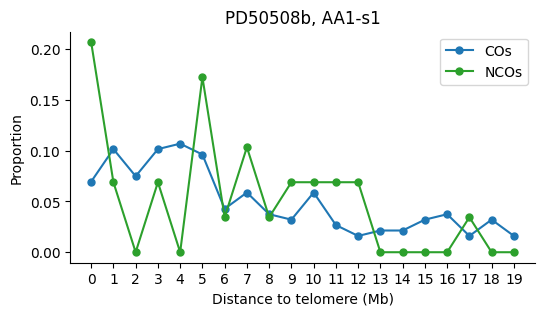

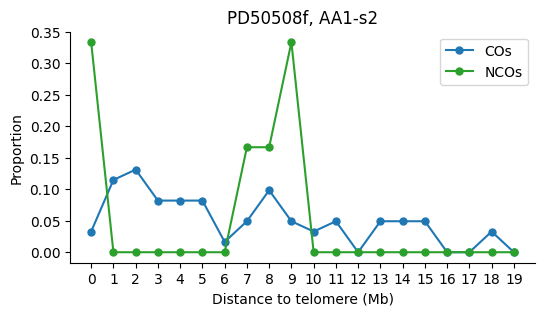

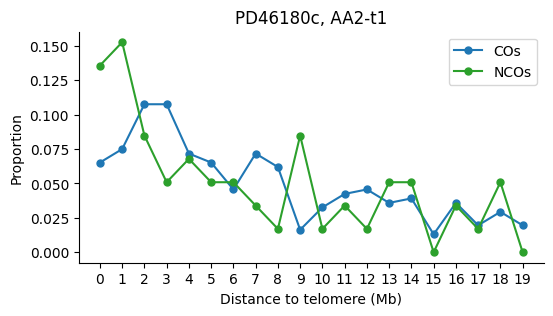

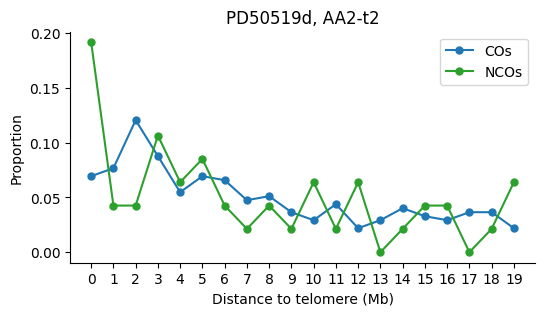

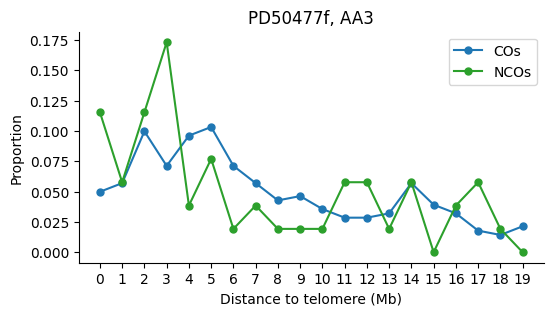

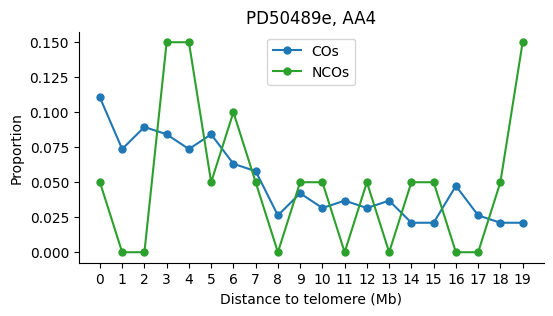

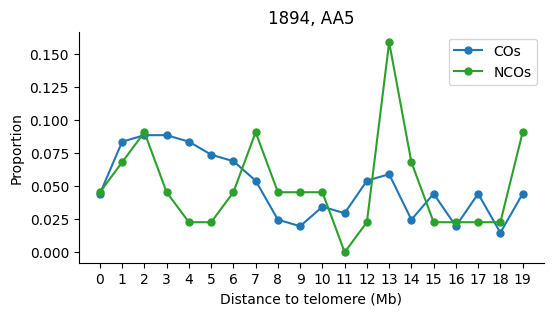

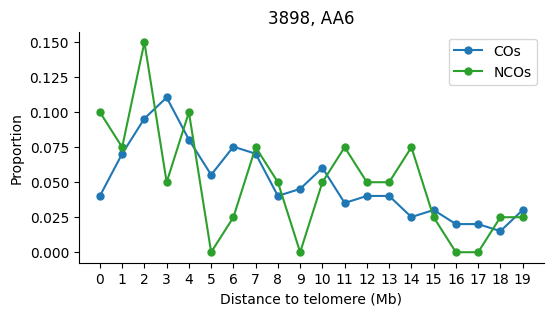

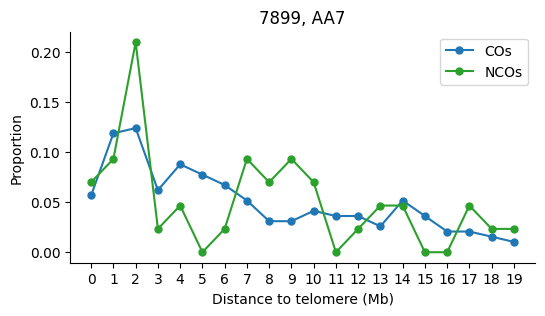

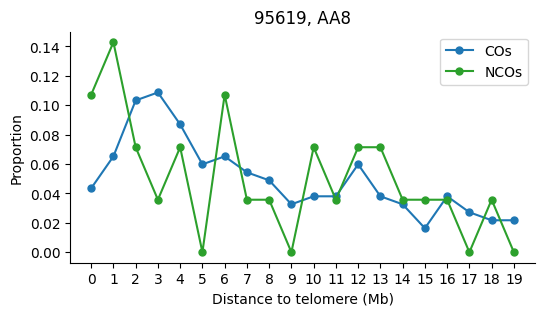

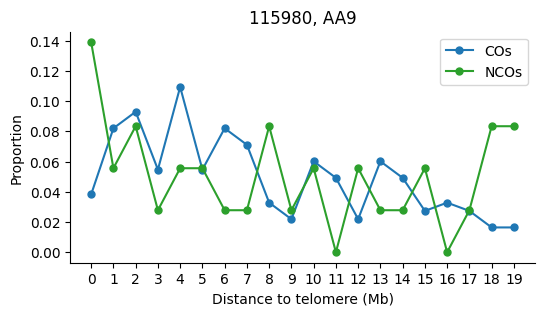

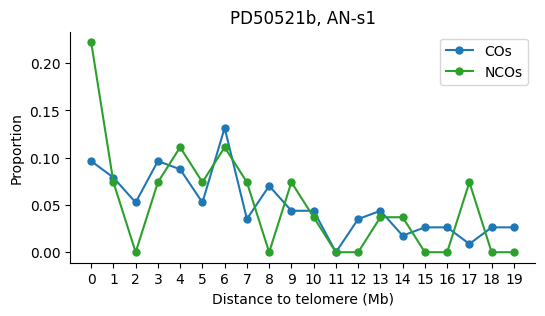

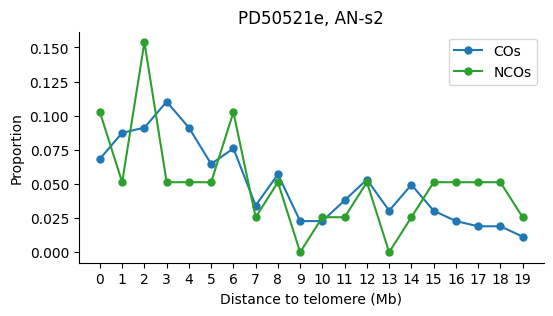

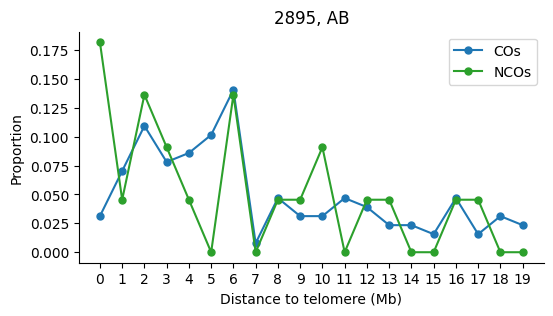

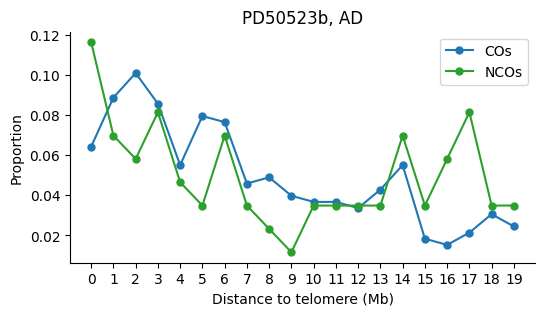

In [9]:
telomere_cutoff = 20e6 
telomere_step = telomere_cutoff/20

min_snps = 5

for sample_id in sample_presentation_order[:-1]:
    # Look at p and q arm separately
    # p arm, exclude acrocentric chroms
    acrocentric_chroms = ["chr13", "chr14", "chr15", "chr21", "chr22"]
    p_arm_distances = (CO_NCO_df
        .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
        .filter(pl.col("sample_id") == sample_id)
        .select(
            "read_name",
            dist_from_p_telomere = pl.when(
                ~pl.col("chrom").is_in(acrocentric_chroms)  
            ).then(
               pl.col("T2T_reference_start") + pl.col("read_length")//2
            )
        )
    )

    # q arm, all chroms
    q_arm_distances = (CO_NCO_df
        .filter(pl.col("sample_id") == sample_id)
        .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
        .join(
            pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),
            on="chrom",
        )
        .select(
            "read_name",
            dist_from_q_telomere = pl.col("T2T_chrom_length") - (pl.col("T2T_reference_start") + pl.col("read_length")//2),
        )
    )

    close_to_telomeres_df = (CO_NCO_df
        .filter(pl.col("sample_id") == sample_id)
        .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
        .join(p_arm_distances, on="read_name")
        .join(q_arm_distances, on="read_name")
        .with_columns(
            distance_to_telomere = pl.min_horizontal("dist_from_p_telomere", "dist_from_q_telomere")
        )
        .filter(pl.col("distance_to_telomere") < telomere_cutoff)
    )

    high_qual_CO_telomere_exp_probs = (close_to_telomeres_df
        .group_by(
            pl.col("distance_to_telomere") // telomere_step
        )
        .agg(
            pl.col("CO_active_interval_crossover_prob").mean().alias("prob")
        )
        .sort("distance_to_telomere")
    )["prob"]

    high_qual_CO_telomere_exp_freqs = high_qual_CO_telomere_exp_probs / high_qual_CO_telomere_exp_probs.sum()


    high_qual_NCO_telomere_exp_probs = (close_to_telomeres_df
        .group_by(
            pl.col("distance_to_telomere") // telomere_step
        )
        .agg(
            (pl.col("NCO_active_interval_crossover_prob") * pl.col("NCO_prob_detection_in_CO_active_interval")).mean().alias("prob")
        )
        .sort("distance_to_telomere")
    )["prob"]

    high_qual_NCO_telomere_exp_freqs = high_qual_NCO_telomere_exp_probs / high_qual_NCO_telomere_exp_probs.sum()

    bins = np.arange(0, telomere_cutoff + telomere_step, telomere_step)

    high_qual_CO_telomere_counts = np.histogram(
        close_to_telomeres_df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["distance_to_telomere"],
        bins=bins,
    )[0]

    high_qual_CO_telomere_freqs = high_qual_CO_telomere_counts / high_qual_CO_telomere_counts.sum()


    high_qual_NCO_telomere_counts = np.histogram(
        close_to_telomeres_df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["distance_to_telomere"],
        bins=bins,
    )[0]

    high_qual_NCO_telomere_freqs = high_qual_NCO_telomere_counts / high_qual_NCO_telomere_counts.sum()

    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(bins[:-1], high_qual_CO_telomere_freqs, '.-', label="COs", ms=10, color=CO_color)
    #ax.plot(bins[:-1], high_qual_CO_telomere_exp_freqs, '.--', label="COs (expected)", ms=5, color="C0", alpha=0.5)

    ax.plot(bins[:-1], high_qual_NCO_telomere_freqs, '.-', label="NCOs", ms=10, color=NCO_color)
    #ax.plot(bins[:-1], high_qual_NCO_telomere_exp_freqs, '.--', label="NCOs (expected)", ms=5, color="C1", alpha=0.5)
    ax.legend();

    ax.set_xticks(
        bins[:-1],
        labels = [f"{int(x/1e6)}" for x in bins[:-1]],
    );

    ax.set_xlabel("Distance to telomere (Mb)");
    ax.set_ylabel("Proportion");
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_title(sample_id + ", " + sample_id_to_paper_label[sample_id])

### Group

/tmp/ipykernel_1505235/3647326769.py:30: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),


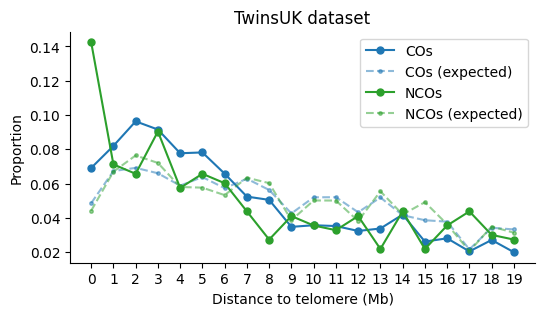

In [13]:
telomere_cutoff = 20e6 
telomere_step = telomere_cutoff/20
min_snps = 3

limited_sample_ids = rahbari_sample_ids
#limited_sample_ids = [x for x in rahbari_sample_ids if x not in ["PD50521b",  "PD50508f"]] # "PD50519d",
#limited_sample_ids = rahbari_sample_ids + sudmant_sample_ids

# Look at p and q arm separately
# p arm, exclude acrocentric chroms
acrocentric_chroms = ["chr13", "chr14", "chr15", "chr21", "chr22"]
p_arm_distances = (CO_NCO_df
    .filter(pl.col("sample_id").is_in(limited_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
    .select(
        "read_name",
        dist_from_p_telomere = pl.when(
            ~pl.col("chrom").is_in(acrocentric_chroms)  
        ).then(
           pl.col("T2T_reference_start") + pl.col("read_length")//2
        )
    )
)

# q arm, all chroms
q_arm_distances = (CO_NCO_df
    .filter(pl.col("sample_id").is_in(limited_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),
        on="chrom",
    )
    .select(
        "read_name",
        dist_from_q_telomere = pl.col("T2T_chrom_length") - (pl.col("T2T_reference_start") + pl.col("read_length")//2),
    )
)

close_to_telomeres_df = (CO_NCO_df
    .filter(pl.col("sample_id").is_in(limited_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
    .join(p_arm_distances, on="read_name")
    .join(q_arm_distances, on="read_name")
    .with_columns(
        distance_to_telomere = pl.min_horizontal("dist_from_p_telomere", "dist_from_q_telomere")
    )
    .filter(pl.col("distance_to_telomere") < telomere_cutoff)
)

high_qual_CO_telomere_exp_probs = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        pl.col("CO_active_interval_crossover_prob").mean().alias("prob")
    )
    .sort("distance_to_telomere")
)["prob"]

high_qual_CO_telomere_exp_freqs = high_qual_CO_telomere_exp_probs / high_qual_CO_telomere_exp_probs.sum()


high_qual_NCO_telomere_exp_probs = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        (pl.col("NCO_active_interval_crossover_prob") * pl.col("NCO_prob_detection_in_CO_active_interval")).mean().alias("prob")
    )
    .sort("distance_to_telomere")
)["prob"]

high_qual_NCO_telomere_exp_freqs = high_qual_NCO_telomere_exp_probs / high_qual_NCO_telomere_exp_probs.sum()

bins = np.arange(0, telomere_cutoff + telomere_step, telomere_step)

high_qual_CO_telomere_counts = np.histogram(
    close_to_telomeres_df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["distance_to_telomere"],
    bins=bins,
)[0]

high_qual_CO_telomere_freqs = high_qual_CO_telomere_counts / high_qual_CO_telomere_counts.sum()


high_qual_NCO_telomere_counts = np.histogram(
    close_to_telomeres_df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["distance_to_telomere"],
    bins=bins,
)[0]

high_qual_NCO_telomere_freqs = high_qual_NCO_telomere_counts / high_qual_NCO_telomere_counts.sum()

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(bins[:-1], high_qual_CO_telomere_freqs, '.-', label="COs", ms=10, color=CO_color)
ax.plot(bins[:-1], high_qual_CO_telomere_exp_freqs, '.--', label="COs (expected)", ms=5, color=CO_color, alpha=0.5)

ax.plot(bins[:-1], high_qual_NCO_telomere_freqs, '.-', label="NCOs", ms=10, color=NCO_color)
ax.plot(bins[:-1], high_qual_NCO_telomere_exp_freqs, '.--', label="NCOs (expected)", ms=5, color=NCO_color, alpha=0.5)



ax.legend();

ax.set_xticks(
    bins[:-1],
    labels = [f"{int(x/1e6)}" for x in bins[:-1]],
);

ax.set_xlabel("Distance to telomere (Mb)");
ax.set_ylabel("Proportion");
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("TwinsUK dataset");

/tmp/ipykernel_1505235/2968872325.py:30: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),


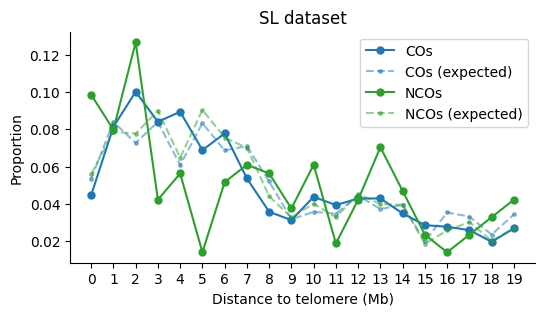

In [14]:
telomere_cutoff = 20e6 
telomere_step = telomere_cutoff/20
min_snps = 3

limited_sample_ids = sudmant_sample_ids
#limited_sample_ids = [x for x in rahbari_sample_ids if x not in ["PD50521b",  "PD50508f"]] # "PD50519d",
#limited_sample_ids = rahbari_sample_ids + sudmant_sample_ids

# Look at p and q arm separately
# p arm, exclude acrocentric chroms
acrocentric_chroms = ["chr13", "chr14", "chr15", "chr21", "chr22"]
p_arm_distances = (CO_NCO_df
    .filter(pl.col("sample_id").is_in(limited_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
    .select(
        "read_name",
        dist_from_p_telomere = pl.when(
            ~pl.col("chrom").is_in(acrocentric_chroms)  
        ).then(
           pl.col("T2T_reference_start") + pl.col("read_length")//2
        )
    )
)

# q arm, all chroms
q_arm_distances = (CO_NCO_df
    .filter(pl.col("sample_id").is_in(limited_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),
        on="chrom",
    )
    .select(
        "read_name",
        dist_from_q_telomere = pl.col("T2T_chrom_length") - (pl.col("T2T_reference_start") + pl.col("read_length")//2),
    )
)

close_to_telomeres_df = (CO_NCO_df
    .filter(pl.col("sample_id").is_in(limited_sample_ids))
    .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
    .join(p_arm_distances, on="read_name")
    .join(q_arm_distances, on="read_name")
    .with_columns(
        distance_to_telomere = pl.min_horizontal("dist_from_p_telomere", "dist_from_q_telomere")
    )
    .filter(pl.col("distance_to_telomere") < telomere_cutoff)
)

high_qual_CO_telomere_exp_probs = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        pl.col("CO_active_interval_crossover_prob").mean().alias("prob")
    )
    .sort("distance_to_telomere")
)["prob"]

high_qual_CO_telomere_exp_freqs = high_qual_CO_telomere_exp_probs / high_qual_CO_telomere_exp_probs.sum()


high_qual_NCO_telomere_exp_probs = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        (pl.col("NCO_active_interval_crossover_prob") * pl.col("NCO_prob_detection_in_CO_active_interval")).mean().alias("prob")
    )
    .sort("distance_to_telomere")
)["prob"]

high_qual_NCO_telomere_exp_freqs = high_qual_NCO_telomere_exp_probs / high_qual_NCO_telomere_exp_probs.sum()

bins = np.arange(0, telomere_cutoff + telomere_step, telomere_step)

high_qual_CO_telomere_counts = np.histogram(
    close_to_telomeres_df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["distance_to_telomere"],
    bins=bins,
)[0]

high_qual_CO_telomere_freqs = high_qual_CO_telomere_counts / high_qual_CO_telomere_counts.sum()


high_qual_NCO_telomere_counts = np.histogram(
    close_to_telomeres_df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["distance_to_telomere"],
    bins=bins,
)[0]

high_qual_NCO_telomere_freqs = high_qual_NCO_telomere_counts / high_qual_NCO_telomere_counts.sum()

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(bins[:-1], high_qual_CO_telomere_freqs, '.-', label="COs", ms=10, color=CO_color)
ax.plot(bins[:-1], high_qual_CO_telomere_exp_freqs, '.--', label="COs (expected)", ms=5, color=CO_color, alpha=0.5)

ax.plot(bins[:-1], high_qual_NCO_telomere_freqs, '.-', label="NCOs", ms=10, color=NCO_color)
ax.plot(bins[:-1], high_qual_NCO_telomere_exp_freqs, '.--', label="NCOs (expected)", ms=5, color=NCO_color, alpha=0.5)



ax.legend();

ax.set_xticks(
    bins[:-1],
    labels = [f"{int(x/1e6)}" for x in bins[:-1]],
);

ax.set_xlabel("Distance to telomere (Mb)");
ax.set_ylabel("Proportion");
ax.spines[['right', 'top']].set_visible(False)
ax.set_title("SL dataset");

### Fisher exact each bin

In [26]:
pl.DataFrame(
    [
        [
            i,
            scipy.stats.fisher_exact(
                [[x, high_qual_CO_telomere_counts.sum() - x],
                 [y, high_qual_NCO_telomere_counts.sum() - y],
                ]
            ).pvalue,
        ]
        for i, (x, y) in enumerate(zip(high_qual_CO_telomere_counts, high_qual_NCO_telomere_counts))
    ],
    schema=["distance_in_Mb", "fisher_exact_pval"]
)

distance_in_Mb,fisher_exact_pval
i64,f64
0,4.8747e-8
1,1.0
2,0.929379
3,0.044205
4,0.006003
5,0.002003
6,0.669427
7,0.563727
8,0.355463


### Average detection probs

In [27]:
full_reads_CO_detection_probs_df = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        (pl.col("CO_active_interval_crossover_prob") / pl.col("full_read_crossover_prob")).mean().alias("prob")
    )
    .sort("distance_to_telomere")
)

full_reads_NCO_detection_probs_df = (close_to_telomeres_df
    .group_by(
        pl.col("distance_to_telomere") // telomere_step
    )
    .agg(
        (pl.col("NCO_prob_detection_in_CO_active_interval") * pl.col("CO_active_interval_crossover_prob") / pl.col("full_read_crossover_prob")).mean().alias("prob")
    )
    .sort("distance_to_telomere")
)

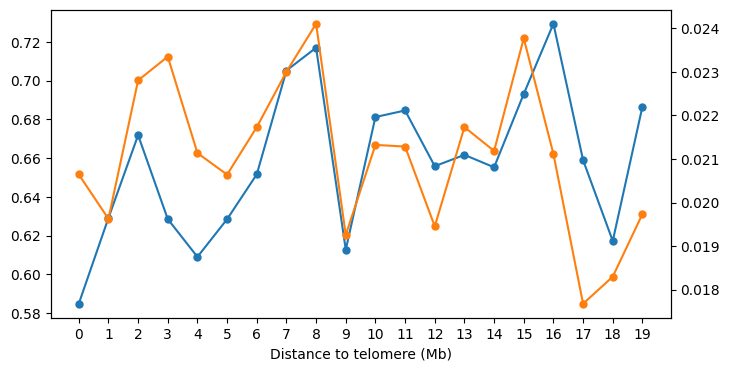

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    full_reads_CO_detection_probs_df["distance_to_telomere"],
    full_reads_CO_detection_probs_df["prob"],
    '.-', ms=10, color="C0"
)

ax2 = ax.twinx() 

ax2.plot(
    full_reads_NCO_detection_probs_df["distance_to_telomere"],
    full_reads_NCO_detection_probs_df["prob"],
    '.-', ms=10, color="C1"
)

ax.set_xticks(
    np.arange(telomere_cutoff / telomere_step),
    labels = [f"{int(x/1e6)}" for x in bins[:-1]],
);

ax.set_xlabel("Distance to telomere (Mb)");


# Correlation between distance to telomere and heat?

In [29]:
AA_hotspots_df = (
    pl.read_csv(
        "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/06.hotspots/hinch_2023_AA_hotspots.csv",
        null_values="NA",
    ).rename({
        "Chromosome": "chrom", 
        "Motif_Centre_Pos": "motif_center_pos",
        "Start_Pos": "hotspot_start_pos",
        "End_Pos": "hotspot_end_pos",    
    })
    .sort("motif_center_pos")
    .set_sorted("motif_center_pos")
)

In [30]:
heat_baseline_df = (AA_hotspots_df
    .filter(pl.col("motif_center_pos") < telomere_cutoff)
    .select(
        (pl.col("motif_center_pos") // (telomere_step/1)).alias("distance_to_telomere"),
        "heat",
    )
    .group_by("distance_to_telomere")
    .agg(pl.col("heat").mean())
    .sort("distance_to_telomere")
)

In [31]:
emp_CO_heat_df = (close_to_telomeres_df
    .select("distance_to_telomere", "AA_heat", "high_quality_classification_in_detectable_class")
    .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
    .drop_nulls() 
    .group_by(pl.col("distance_to_telomere") // telomere_step)
    .agg(pl.col("AA_heat").mean())
    .sort("distance_to_telomere")
)

emp_NCO_heat_df = (close_to_telomeres_df
    .select("distance_to_telomere", "AA_heat", "high_quality_classification_in_detectable_class")
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .drop_nulls() 
    .group_by(pl.col("distance_to_telomere") // telomere_step)
    .agg(pl.col("AA_heat").mean())
    .sort("distance_to_telomere")
)

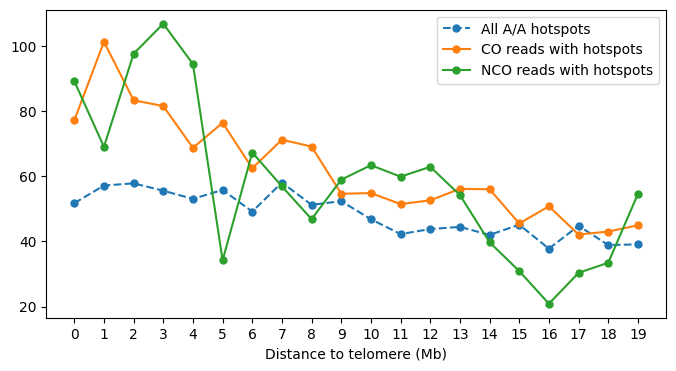

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    heat_baseline_df["distance_to_telomere"],
    heat_baseline_df["heat"],
    '.--',
    ms=10,
    label="All A/A hotspots",
);

ax.plot(
    emp_CO_heat_df["distance_to_telomere"],
    emp_CO_heat_df["AA_heat"],
    '.-',
    ms=10,
    label="CO reads with hotspots",
);

ax.plot(
    emp_NCO_heat_df["distance_to_telomere"],
    emp_NCO_heat_df["AA_heat"],
    '.-',
    ms=10,
    label="NCO reads with hotspots",
);

ax.legend();
ax.set_xticks(
    np.arange(len(bins)-1),
    labels = [f"{int(x/1e6)}" for x in bins[:-1]],
);

ax.set_xlabel("Distance to telomere (Mb)");


# Is signal driven by NCOs in last 1Mb?

## How much of them are in the last 1Mb?

In [33]:
df = (close_to_telomeres_df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter(pl.col("distance_to_telomere") < 1e6)
)

n_ncos_near_telomere = len(df)
ncos_near_telomere_read_names = df["read_name"]

display(df.group_by("sample_id").len())

sample_id,len
str,u32
"""PD46180c""",1
"""PD50489e""",1
"""PD50508b""",2
"""115980""",6
"""PD50521b""",12
"""PD50508f""",2
"""7899""",12
"""PD50477f""",3
"""3898""",5


In [34]:
n_ncos_total = len(dense_reads_with_detection_df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO"))

In [35]:
print(n_ncos_near_telomere, n_ncos_total, n_ncos_near_telomere / n_ncos_total)

65 1091 0.05957836846929423


## Are cM differences driven by last 1Mb?

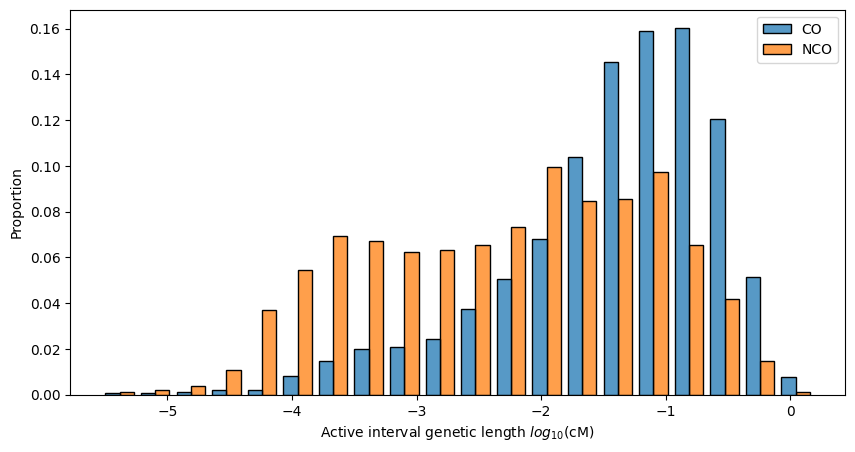

In [36]:
fig, ax = plt.subplots(figsize=(10,5))

df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "read_name",
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = (df
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter(~pl.col("read_name").is_in(ncos_near_telomere_read_names))
)["CO_active_interval_crossover_prob"] * 1e2
    

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
    ], 
    bins=20, 
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length $log_{10}$(cM)");


## Genetic lengths between samples

In [37]:
sample_id_to_active_interval_lengths = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter((pl.col("sample_id") == sample_id) & (pl.col("high_quality_classification_in_detectable_class") == "NCO"))
        .filter(~pl.col("read_name").is_in(ncos_near_telomere_read_names))
    )
    lens = sdf["CO_active_interval_crossover_prob"] * 1e2
    
    sample_id_to_active_interval_lengths[sample_id] = lens.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    lens_1 = sample_id_to_active_interval_lengths[sample_id1]
    lens_2 = sample_id_to_active_interval_lengths[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(lens_1), 
            len(lens_2),
            scipy.stats.ks_2samp(lens_1, lens_2).pvalue,
            inference.permutation_testing([[lens_1, lens_2]], 1000),
        ]
    )
    
pairwise_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "lens_ks_pvalue", 
            "lens_AD_perm_pvalue", ],
)    

100%|██████████| 105/105 [00:23<00:00,  4.38it/s]


In [38]:
pairwise_nco_df.sort("lens_AD_perm_pvalue")

sample_id1,sample_id2,n1,n2,lens_ks_pvalue,lens_AD_perm_pvalue
str,str,i64,i64,f64,f64
"""1894""","""3898""",160,125,0.000062,0.0
"""1894""","""7899""",160,126,0.001912,0.001
"""1894""","""PD50523b""",160,60,0.001575,0.001
"""115980""","""3898""",111,125,0.055312,0.003
"""1894""","""PD50521b""",160,47,0.002346,0.004
"""1894""","""PD46180c""",160,42,0.014522,0.01
"""3898""","""PD50519d""",125,39,0.011507,0.01
"""1894""","""PD50521e""",160,33,0.00957,0.012
"""2895""","""3898""",89,125,0.021875,0.015


### Sample vs. rest

In [39]:
rows = []
for sample_id in tqdm.tqdm(sample_id_order):
    pairs = [
        [
            sample_id_to_active_interval_lengths[sample_id],
            sample_id_to_active_interval_lengths[other_sample_id],
        ]
        for other_sample_id in sample_ids if other_sample_id != sample_id 
    ]
    lens_1 = sample_id_to_active_interval_lengths[sample_id]
    rows.append(
        [
            sample_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
sample_vs_rest_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_in_sample", "AD_perm_pvalue"],
)

100%|██████████| 15/15 [00:47<00:00,  3.20s/it]


In [40]:
sample_vs_rest_df.sort("AD_perm_pvalue")

sample_id,n_in_sample,AD_perm_pvalue
str,i64,f64
"""1894""",160,0.0
"""3898""",125,0.0
"""PD50523b""",60,0.0
"""PD50519d""",39,0.002
"""PD50489e""",15,0.008
"""115980""",111,0.018
"""2895""",89,0.031
"""7899""",126,0.053
"""PD50521b""",47,0.056


# ENCODE H3K4me3

In [41]:
rows = []
for sample_id in tqdm.tqdm(sample_id_order):
    heats_CO = (CO_NCO_df
        .filter(pl.col("grch37_reference_start").is_not_null())                
        .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
        .filter((pl.col("sample_id") == sample_id))
    )["H3K4me3_signal_mean"].fill_null(0).to_numpy()

    heats_NCO = (CO_NCO_df
        .filter(pl.col("grch37_reference_start").is_not_null())                 
        .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
        .filter((pl.col("sample_id") == sample_id))
    )["H3K4me3_signal_mean"].fill_null(0).to_numpy()
    
    rows.append(
        [
            sample_id, 
            len(heats_CO), 
            len(heats_NCO),
            (heats_CO == 0).sum(),
            (heats_NCO == 0).sum(),
            scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
            inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
            inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
                 [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
            ).pvalue,
        ]
    )
    
H3K4me3_heats_co_vs_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_CO", "n_NCO", "n_CO_zeros", "n_NCO_zeros",
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

H3K4me3_heats_co_vs_nco_df.sort("heats_AD_perm_pvalue")

100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


sample_id,n_CO,n_NCO,n_CO_zeros,n_NCO_zeros,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,i64,i64,i64,i64,f64,f64,f64,f64
"""1894""",444,162,10,5,0.00075,0.0,0.0,0.560189
"""95619""",373,110,3,2,0.000051,0.0,0.0,0.320128
"""115980""",363,114,4,3,0.009428,0.0,0.0,0.365643
"""3898""",390,127,4,3,0.031119,0.006,0.009,0.370709
"""7899""",443,136,15,4,0.049199,0.007,0.002,1.0
"""PD50519d""",135,41,1,0,0.061421,0.04,0.049,1.0
"""PD50477f""",153,30,4,0,0.089585,0.04,0.036,1.0
"""PD50521b""",193,53,2,5,0.286396,0.07,0.564,0.005819
"""PD50508b""",129,29,3,0,0.257972,0.137,0.049,1.0


/tmp/ipykernel_960294/3906849803.py:15: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(


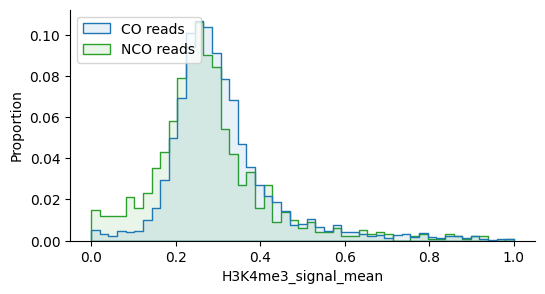

In [42]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
#    .filter(pl.col("sample_id") == sample_id)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "H3K4me3_signal_mean",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["H3K4me3_signal_mean"]
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["H3K4me3_signal_mean"]
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["H3K4me3_signal_mean"]

sns.histplot(
    [
        pd.Series((CO_lens), name="CO"),
        pd.Series((NCO_lens), name="NCO"),
        #pd.Series((all_lens), name="All reads"),
    ], 
    #bins=np.linspace(-1, 0, 50),
    bins=np.linspace(0, 1, 50),
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
)

ax.set_xlabel("H3K4me3_signal_mean");
# ax.set_xticks(
#     np.arange(-5, 1),
#     [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
# );
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)

# CTCF

In [43]:
rows = []
for sample_id in tqdm.tqdm(sample_id_order):
    heats_CO = (CO_NCO_df
        .filter(pl.col("grch37_reference_start").is_not_null())                
        .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
        .filter((pl.col("sample_id") == sample_id))
    )["CTCF_signal_mean"].fill_null(0).to_numpy()

    heats_NCO = (CO_NCO_df
        .filter(pl.col("grch37_reference_start").is_not_null())                 
        .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
        .filter((pl.col("sample_id") == sample_id))
    )["CTCF_signal_mean"].fill_null(0).to_numpy()
    
    rows.append(
        [
            sample_id, 
            len(heats_CO), 
            len(heats_NCO),
            (heats_CO == 0).sum(),
            (heats_NCO == 0).sum(),
            scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
            inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
            inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
                 [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
            ).pvalue,
        ]
    )
    
CTCF_heats_co_vs_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_CO", "n_NCO", "n_CO_zeros", "n_NCO_zeros",
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

CTCF_heats_co_vs_nco_df.sort("heats_AD_perm_pvalue")

100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


sample_id,n_CO,n_NCO,n_CO_zeros,n_NCO_zeros,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,i64,i64,i64,i64,f64,f64,f64,f64
"""7899""",443,136,15,4,0.000102,0.0,0.0,1.0
"""95619""",373,110,3,2,0.00298,0.0,0.0,0.320128
"""115980""",363,114,4,3,0.017706,0.0,0.001,0.365643
"""2895""",304,89,2,0,0.005775,0.004,0.0,1.0
"""PD50521b""",193,53,2,6,0.004986,0.008,0.075,0.001538
"""1894""",444,162,10,5,0.092875,0.022,0.024,0.560189
"""PD46180c""",213,39,1,1,0.149081,0.096,0.125,0.286094
"""PD50519d""",135,41,1,0,0.208407,0.112,0.142,1.0
"""PD50508f""",105,16,2,0,0.051486,0.129,0.092,1.0


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


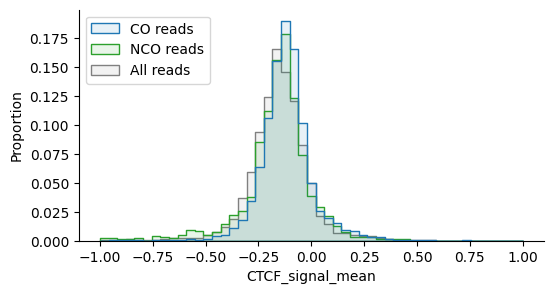

In [44]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
#    .filter(pl.col("sample_id") == sample_id)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "CTCF_signal_mean",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CTCF_signal_mean"]
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CTCF_signal_mean"]
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["CTCF_signal_mean"]

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=np.linspace(-1, 1, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
)

ax.set_xlabel("CTCF_signal_mean");
# ax.set_xticks(
#     np.arange(-5, 1),
#     [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
# );
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)

# HumCFS

In [34]:
import glob

fragile_df = pl.concat([
    pl.read_csv(
        filename,
        new_columns = ["chrom", "start_pos", "end_pos", "fragile_site_name", "something", "something_else"],
        separator = "\t",
        infer_schema = False,
    ) \
        for filename in glob.glob("/lustre/scratch122/tol/projects/sperm/data/references/10.HumCFS/fragile_site_bed/chr*_fragile_site.bed")
])

In [35]:
# subsample = dense_reads_with_detection_df.sample(fraction=0.0001)
# print("subsampled")

dfs = []
for chrom in tqdm.tqdm(aut_chrom_names):
    dfs.append(CO_NCO_df
        .filter(pl.col("chrom") == chrom)
        .select("read_name", "chrom",  "grch38_reference_start", "grch38_reference_end")
        .sort("grch38_reference_start")
        .set_sorted("grch38_reference_start")
        .join_asof(
            (fragile_df
                .filter(pl.col("chrom") == chrom)
                .select(
                    region_start_pos=pl.col("start_pos").cast(int), 
                    region_end_pos=pl.col("end_pos").cast(int), 
                )
                .sort("region_end_pos")
            ),
            left_on="grch38_reference_start",
            right_on="region_end_pos",
            strategy="forward",
        )
        .with_columns(
            in_fragile_site = (
                pl.col("grch38_reference_start").is_not_null() & 
                pl.col("grch38_reference_end").is_not_null() & 
                pl.col("region_start_pos").is_not_null() & 
                pl.col("region_end_pos").is_not_null() & 
                (pl.col("grch38_reference_start") >= pl.col("region_start_pos")) &
                (pl.col("grch38_reference_end") <= pl.col("region_end_pos"))
            )
        )
    )
    
reads_in_fragile_df = pl.concat(dfs)

100%|██████████| 22/22 [00:00<00:00, 205.18it/s]


In [36]:
reads_in_fragile_df.select("in_fragile_site").mean()

in_fragile_site
f64
0.219135


In [37]:
CO_NCO_with_fragile_df = (CO_NCO_df
    .join(
        reads_in_fragile_df.select("read_name", "in_fragile_site"),
        on="read_name", 
        how="left",
    )
)

In [38]:
xdf = (CO_NCO_with_fragile_df
    .filter(pl.col("high_quality_classification_class") == "GC")
    .select("in_fragile_site", "CO_active_interval_crossover_prob")
)

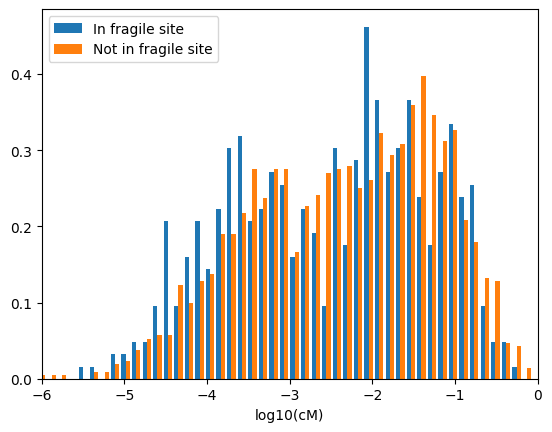

In [39]:
plt.hist([
    xdf.filter(pl.col("in_fragile_site"))["CO_active_interval_crossover_prob"].log(base=10)+2,
    xdf.filter(~pl.col("in_fragile_site"))["CO_active_interval_crossover_prob"].log(base=10)+2,
    ],
    bins=50,
    density=True,
);
plt.legend(["In fragile site", "Not in fragile site"]);
plt.xlabel("log10(cM)");
plt.xlim(-6,0);

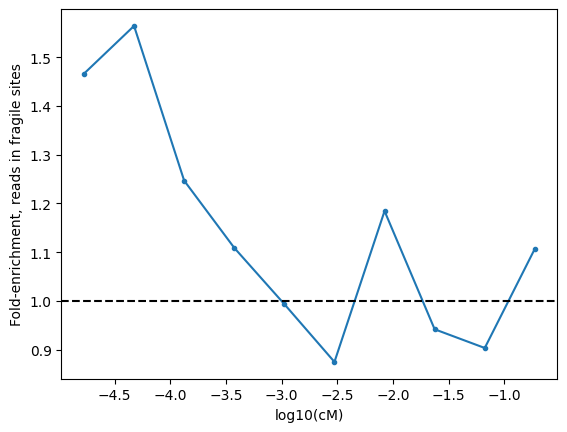

In [40]:
fragile_cm_bins = np.linspace(-5, -0.5, 11)
bin_starts = fragile_cm_bins[:-1]
bin_ends = fragile_cm_bins[1:]
fragile_fractions = []
for s,e in zip(bin_starts, bin_ends):
    tdf = xdf.filter((pl.col("CO_active_interval_crossover_prob").log(base=10)+2).is_between(s,e))
    fragile_fractions.append(tdf["in_fragile_site"].mean())
    
plt.plot(
    (bin_starts + bin_ends)/2,
    np.array(fragile_fractions) / 0.217,
    '.-',
);

plt.axhline(1.0, color="black", ls="dashed");
plt.xlabel("log10(cM)");
plt.ylabel("Fold-enrichment, reads in fragile sites");

In [92]:
0.27/0.21

1.2857142857142858

In [62]:
(xdf
    .select(
        "in_fragile_site",
        is_low = (pl.col("CO_active_interval_crossover_prob").log(base=10)+2) < -2,
    )
    .group_by("in_fragile_site", "is_low")
    .len()
)

in_fragile_site,is_low,len
bool,bool,u32
false,true,514
false,false,1138
true,true,183
true,false,308


In [67]:
scipy.stats.fisher_exact([[183, 514], [308, 1138]])

SignificanceResult(statistic=np.float64(1.3154656627419274), pvalue=np.float64(0.011600534325133959))

In [68]:
308/(308+1138)

0.21300138312586445

In [69]:
ydf = (CO_NCO_with_fragile_df
    .filter(pl.col("high_quality_classification_class") == "CO")
    .select("in_fragile_site", "CO_active_interval_crossover_prob")
)

In [72]:
ydf["in_fragile_site"].sum(), len(ydf)

(1410, 6532)

In [73]:
scipy.stats.fisher_exact([[183, 514], [1410, 6532]])

SignificanceResult(statistic=np.float64(1.649358390595248), pvalue=np.float64(1.0312967080661038e-07))

In [63]:
scipy.stats.binomtest(183, 183+514, 0.21)

BinomTestResult(k=183, n=697, alternative='two-sided', statistic=0.26255380200860834, pvalue=0.0009420719877058272)

In [64]:
183/(183+514)

0.26255380200860834

In [59]:
scipy.stats.binomtest(443, 443+1473, 0.21)

BinomTestResult(k=443, n=1916, alternative='two-sided', statistic=0.23121085594989563, pvalue=0.024812169649901433)

In [52]:
scipy.stats.binomtest(48, 48+179, 0.21)

BinomTestResult(k=48, n=227, alternative='two-sided', statistic=0.21145374449339208, pvalue=0.935162121636193)

SignificanceResult(statistic=np.float64(0.8412173630001627), pvalue=np.float64(0.10767042303425034))

In [29]:
scipy.stats.ks_2samp(
    xdf.filter(pl.col("in_fragile_site"))["CO_active_interval_crossover_prob"].log(base=10)+2,
    xdf.filter(~pl.col("in_fragile_site"))["CO_active_interval_crossover_prob"].log(base=10)+2,
)

KstestResult(statistic=np.float64(0.08113106128225739), pvalue=np.float64(0.012810594310752314), statistic_location=np.float64(-3.4878801413720293), statistic_sign=np.int8(1))

In [53]:
scipy.stats.ttest_ind(
    xdf.filter(pl.col("in_fragile_site"))["CO_active_interval_crossover_prob"].log(base=10)+2,
    xdf.filter(~pl.col("in_fragile_site"))["CO_active_interval_crossover_prob"].log(base=10)+2,
)

TtestResult(statistic=np.float64(-2.6807140792842845), pvalue=np.float64(0.007402871658641256), df=np.float64(2141.0))

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
LR = LogisticRegression().fit(
    np.log10(xdf["CO_active_interval_crossover_prob"].to_numpy() * 1e2)[:, np.newaxis], 
    xdf["in_fragile_site"].to_numpy().astype(int)
)


In [33]:
xs = np.linspace(-5, 0, 100)
ys = LR.predict_proba(xs.reshape(-1, 1))

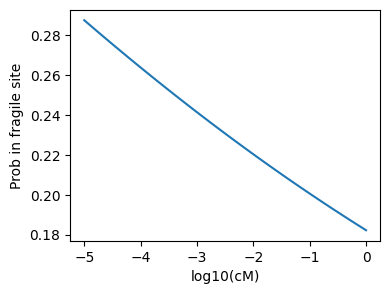

In [34]:
plt.figure(figsize=(4,3));
plt.plot(xs, ys[:,1]);
plt.xlabel("log10(cM)");
plt.ylabel("Prob in fragile site");

In [35]:
import statsmodels.api as sm
sm_model = sm.Logit(
    xdf["in_fragile_site"].to_numpy().astype(int), 
    np.log10(xdf["CO_active_interval_crossover_prob"].to_numpy() * 1e2)[:, np.newaxis],
).fit(disp=0)
print(sm_model.pvalues)
sm_model.summary()

[5.58117429e-90]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2143
Model:                          Logit   Df Residuals:                     2142
Method:                           MLE   Df Model:                            0
Date:                Thu, 27 Mar 2025   Pseudo R-squ.:                -0.07025
Time:                        19:55:36   Log-Likelihood:                -1234.4
converged:                       True   LL-Null:                       -1153.4
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4092      0.020     20.114      0.000       0.369       0.449
==============================================================================
"""

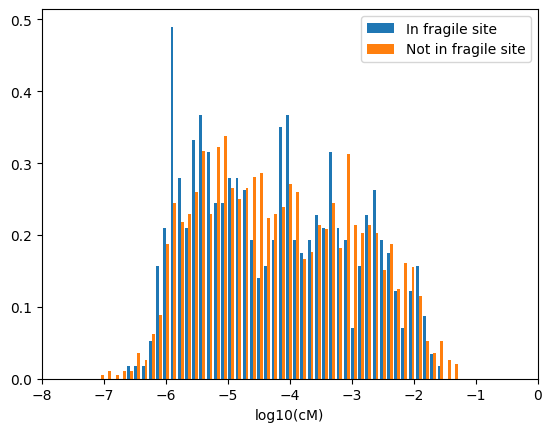

In [100]:
xdf = (CO_NCO_with_fragile_df
    .filter(pl.col("high_quality_classification_class") == "GC")
    .select("in_fragile_site", "grch37_first_converted_marker_poses_rate")
)

plt.hist([
    xdf.filter(pl.col("in_fragile_site"))["grch37_first_converted_marker_poses_rate"].log(base=10)+2,
    xdf.filter(~pl.col("in_fragile_site"))["grch37_first_converted_marker_poses_rate"].log(base=10)+2,
    ],
    bins=50,
    density=True,
);
plt.legend(["In fragile site", "Not in fragile site"]);
plt.xlabel("log10(cM)");
plt.xlim(-8,0);

# Paper figure

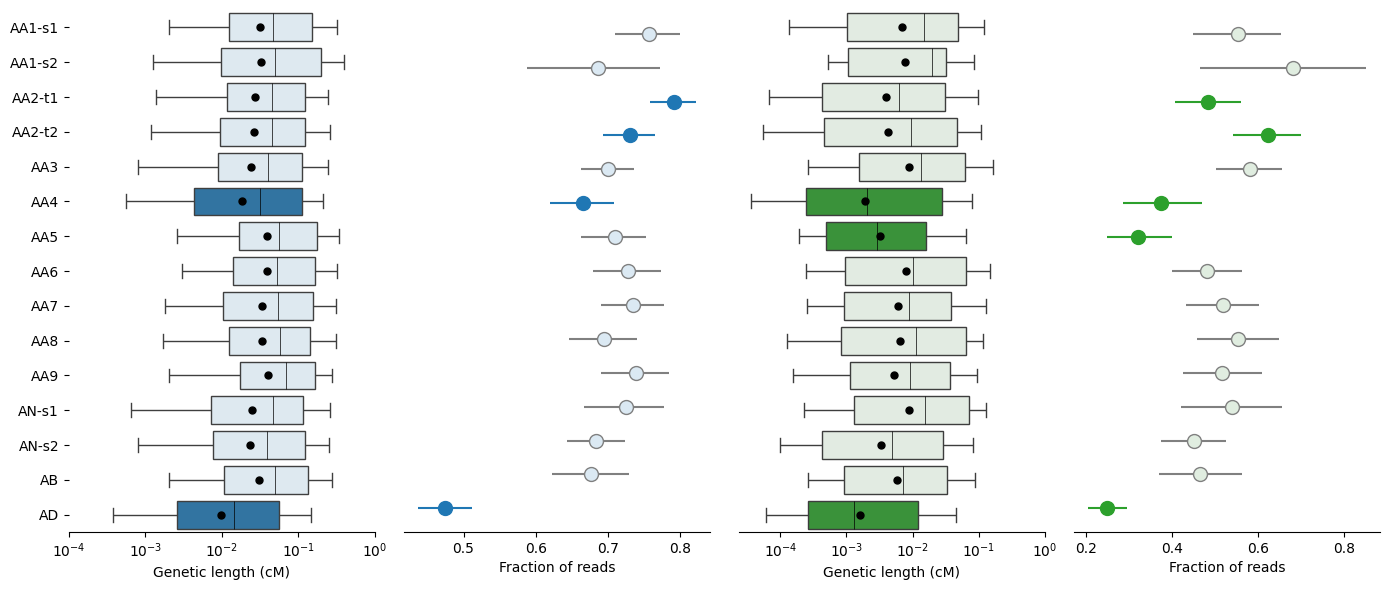

In [30]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(14, 6),
    width_ratios=[25, 25, 25, 25],
)


inference.plot_boxplots_samples(
    test_df = (CO_NCO_df
        .filter(pl.col("high_quality_classification_class") == "CO")
        .with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2)
    ),
    test_column = "cM",
    xlabel = "Genetic length (cM)",
    take_log10=True,
    ticks = np.arange(-4, 1),
    label_to_color={
        # "AN-s1": CO_color,
        # "AN-s2": CO_color,
        # "AB": CO_color,
        "AD": CO_color,
        "AA4": CO_color,
        # "AA1-s1": CO_color,
        # "AA1-s2": CO_color,
    },
    default_color = "#dbe9f3",
    ax = axs[0],
);

ax = axs[1] 
for i in range(len(mns_co)):
    color = "grey"
    fill_color = '#dbe9f3'
    if sample_id_to_paper_label[sample_presentation_order[i]] in ["AD", "AA4", "AA2-t1", "AA2-t2"]:
        color = CO_color
        fill_color = CO_color
        
        
    ax.errorbar(
        y = i,
        x = mns_co[i],
        xerr = [[mns_co[i] - cis_co[i][0]], [cis_co[i][1] - mns_co[i]]],
        color=color,
        marker='o', 
        mfc=fill_color, #'#dbe9f3',
        ms=10,
    )
ax.invert_yaxis()
ax.set_yticks([], [])
ax.set_xlabel("Fraction of reads");
ax.spines[['top', 'right', 'left']].set_visible(False)
    


# inference.plot_boxplots_samples(
#     test_df = (CO_NCO_df
#         .filter(pl.col("high_quality_classification_class") == "CO")
#     ),
#     test_column = "H3K4me3_signal_mean",
#     xlabel = "H3K4me3 signal average",
#     take_log10 = True,
#     ticks = np.arange(-1, 1),
#     label_to_color={
#         # "AA2-t2": CO_color,
#         # "AA8": CO_color,
#     },
#     show_labels = False,
#     ax = axs[2]
# );




inference.plot_boxplots_samples(
    test_df = (CO_NCO_df
        .filter(pl.col("high_quality_classification_class") == "GC")
        .with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2)
    ),
    test_column = "cM",
    xlabel = "Genetic length (cM)",
    take_log10 = True,
    ticks = np.arange(-4, 1),
    label_to_color={
        "AA5": NCO_color,
        "AA4": NCO_color,
        "AD": NCO_color,
    },
    show_labels = False,
    default_color = "#e0ede0",
    ax = axs[2]
);




# NCOs
mns_nco = [(1 - Drows[s]["n_NCO_zeros"]/Drows[s]["n_NCO"]) \
       for s in sample_presentation_order[:-1]]
cis_nco = [statsmodels.stats.proportion.proportion_confint(
    Drows[s]["n_NCO"] - Drows[s]["n_NCO_zeros"],
    Drows[s]["n_NCO"],
    method="beta",
) for s in sample_presentation_order[:-1]]

ax = axs[3]
for i in range(len(mns_co)):
    color = "grey"
    fill_color = "#e0ede0"
    if sample_id_to_paper_label[sample_presentation_order[i]] in ["AA4", "AA5", "AA2-t1", "AA2-t2", "AD"]:
        color = NCO_color
        fill_color = NCO_color
        
    ax.errorbar(
        y = i,
        x = mns_nco[i],
        xerr = [[mns_nco[i] - cis_nco[i][0]], [cis_nco[i][1] - mns_nco[i]]],
        color=color,
        marker='o', 
        mfc=fill_color,
        ms=10,
    )
ax.invert_yaxis()
ax.set_yticks([], [])
ax.set_xlabel("Fraction of reads");
ax.spines[['top', 'right', 'left']].set_visible(False)



# inference.plot_boxplots_samples(
#     test_df = (CO_NCO_df
#         .filter(pl.col("high_quality_classification_class") == "GC")
#     ),
#     test_column = "H3K4me3_signal_mean",
#     xlabel = "H3K4me3 signal average",
#     take_log10 = True,
#     ticks = np.arange(-1, 1),
#     label_to_color={
#         # "AA3": NCO_color,
#         # "AA4": NCO_color,
#         # "AA6": NCO_color,
#         # "AA2-t1": NCO_color,
#     },
#     show_labels = False,
#     ax = axs[5]
# );




fig.tight_layout();

fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/revision/ind_var.pdf")